<a href="https://colab.research.google.com/github/neuroqudit/pyngn/blob/main/notebooks/02_delayed_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Delayed Memory (Oligodendrocytes)

This notebook demonstrates how synaptic delays allow the network to retain information over time.

## Oligodendrocyte Dynamics (Temporal Delays)

Oligodendrocytes adjust the conduction velocity (delay $D_{ij}$) to enrich the temporal diversity of the reservoir.

### Delay Plasticity
$$ D_{ij}(t+1) = D_{ij}(t) + \Delta D $$
This allows the network to maintain a "delay memory", preventing excessive synchrony and enabling the processing of spatiotemporal patterns.

In [ ]:
!pip install pyngn

In [2]:
import torch
import matplotlib.pyplot as plt
from pyngn.neuron import LIFLayer
from pyngn.synapse import DelayBuffer

%matplotlib inline

## Setup Network with Delays

We create a simple setup: Source Neuron -> Target Neuron with a specific delay.

In [3]:
n_neurons = 2
max_delay = 20
dt = 1.0

layer = LIFLayer(n_neurons, tau_m=10.0, v_th=1.0, dt=dt)
buffer = DelayBuffer(n_neurons, max_delay=max_delay)

# Connectivity: Neuron 0 -> Neuron 1 with delay 15
# Neuron 0 -> Neuron 0 (self) with delay 0 (ignored/no connection)
weights = torch.tensor([[0.0, 1.5],  # 0->0, 0->1
                        [0.0, 0.0]]) # 1->0, 1->1

delays = torch.tensor([[1, 15],      # 0->0 (dummy), 0->1 (15ms)
                       [1, 1]])      # dummy

delays = delays.long()

## Simulation

In [5]:
duration = 100
spike_trace = []
voltage_trace = []

layer.reset_state()
buffer.reset_state()

for t in range(duration):
    # External input only to Neuron 0 at t=10
    i_ext = torch.zeros(n_neurons)
    if t == 10:
        i_ext[0] = 2.0 # Force spike

    # 1. Get delayed spikes from buffer
    # delayed_spikes[i, j] is spike from i arriving at j
    delayed_spikes = buffer.get_delayed_spikes(delays)

    # 2. Calculate synaptic current
    # I_syn[j] = sum_i (W[i, j] * delayed_spikes[i, j])
    # We need to be careful with dimensions.
    # weights: [n_pre, n_post]
    # delayed_spikes: [n_pre, n_post]
    current_in = (weights * delayed_spikes).sum(dim=0) # Sum over pre-synaptic neurons

    # 3. Update neurons
    s = layer.forward(i_syn=current_in, i_ext=i_ext)

    # 4. Push new spikes to buffer
    buffer.push(s)

    spike_trace.append(s.clone().numpy())
    voltage_trace.append(layer.v.clone().numpy())

import numpy as np
spike_trace = np.array(spike_trace)
voltage_trace = np.array(voltage_trace)

## Visualization
Neuron 0 should spike at t=10. Neuron 1 should spike at t=10+15=25 (approx).

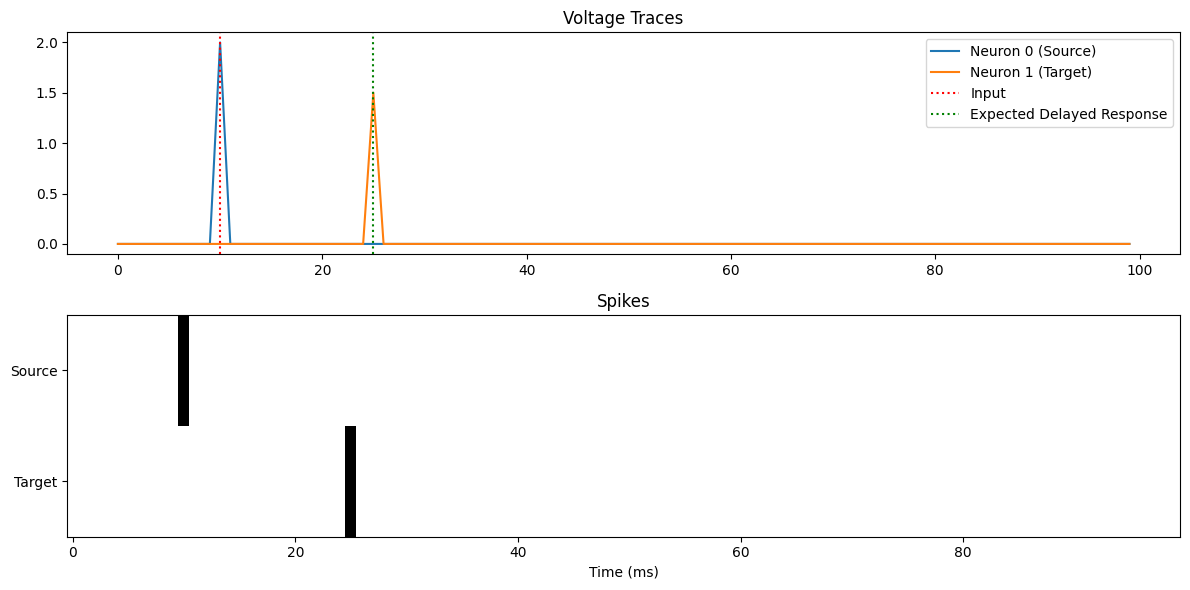

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(voltage_trace[:, 0], label='Neuron 0 (Source)')
plt.plot(voltage_trace[:, 1], label='Neuron 1 (Target)')
plt.axvline(10, color='r', linestyle=':', label='Input')
plt.axvline(25, color='g', linestyle=':', label='Expected Delayed Response')
plt.legend()
plt.title('Voltage Traces')

plt.subplot(2, 1, 2)
plt.imshow(spike_trace.T, aspect='auto', cmap='Greys', interpolation='nearest')
plt.yticks([0, 1], ['Source', 'Target'])
plt.xlabel('Time (ms)')
plt.title('Spikes')
plt.tight_layout()
plt.show()